# Exploring the gene-level epigenetic features

The key questions we need to establish are 
1. Do these measures contain non-trivial relationships with transcriptomics, are they independent or too highly correlated?
2. What is the scale of the values? Do they need transformation?
3. Which if any are predictive of expression following perturbation?


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


/tmp/dmichael_myenv/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [3]:
ds = pd.read_parquet("/dccstor/bmfm-targets/data/omics/epigenome/datastore.parquet")

In [4]:
shared_measurements = ds.dropna(thresh=100000, axis=1)
# Concat and correlate
A = shared_measurements.query('biosample_name == "K562"').set_index('gene_symbol').loc[shared_measurements.gene_symbol.unique()].iloc[:, 1:]
B = shared_measurements.query('biosample_name == "H1"').set_index('gene_symbol').loc[shared_measurements.gene_symbol.unique()].iloc[:, 1:]



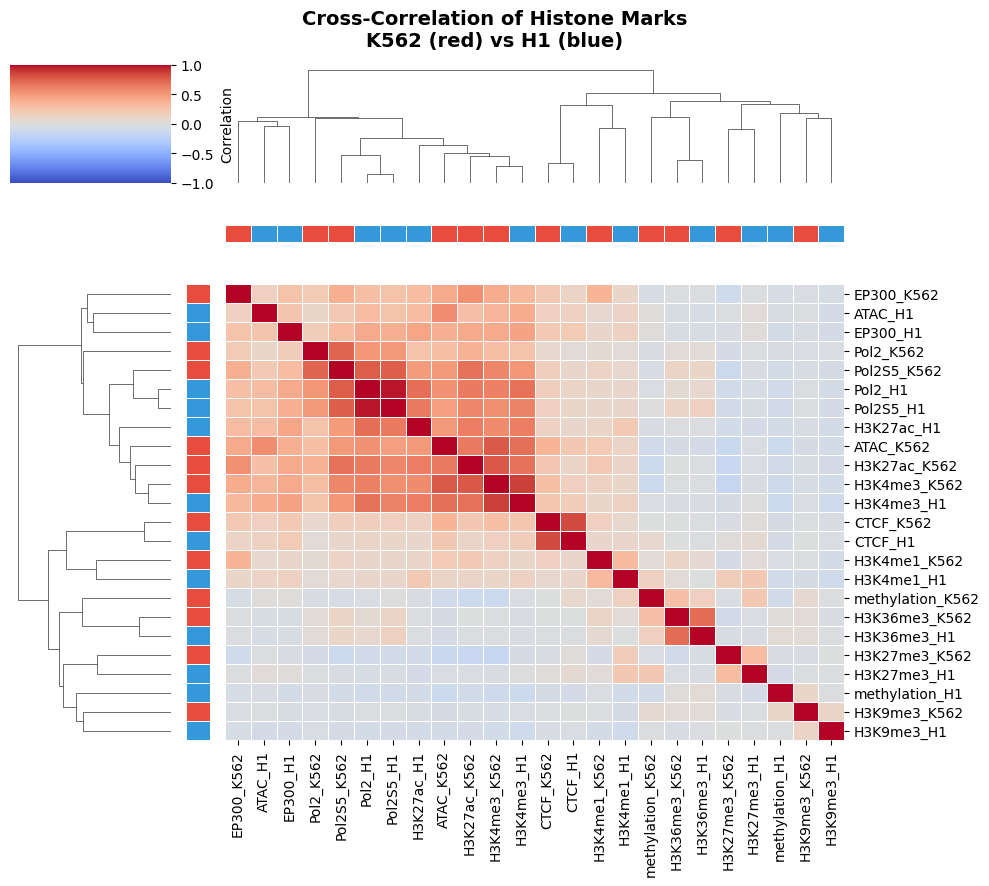

In [5]:
# Concatenate and compute correlation
combined = pd.concat([A, B], axis=1)
combined.columns = [f"{col}_K562" for col in A.columns] + [
    f"{col}_H1" for col in B.columns
]
corr_matrix = combined.corr().fillna(0)

# Create color map for the sides
n_marks = len(A.columns)
row_colors = ["#e74c3c"] * n_marks + ["#3498db"] * n_marks  # Red for K562, Blue for H1

# Create the clustermap with side colors
g = sns.clustermap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    row_colors=row_colors,
    col_colors=row_colors,
    figsize=(10, 9),
    cbar_kws={"label": "Correlation"},
    linewidths=0.5,
)

plt.suptitle(
    "Cross-Correlation of Histone Marks\nK562 (red) vs H1 (blue)",
    y=0.98,
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

We see that in general the measurements of a given column are more similar to one another across cell lines than the measurement of different features within the same cell line.

We see that a few `H3K` are most closely correlated: `27ac`, `4me3` and somewhat less closely `4me1`. It's quite unlikely we'll see some benefit from including all three of them rather than choosing others. For some reason `36me3` is closer to methylation than the other chipseqs. And `9me3` is very different from everything else, almost orthogonal. We also see that H1 methylation is rather different from the others, more similar to 9me3 K562 than anything else. Weird.

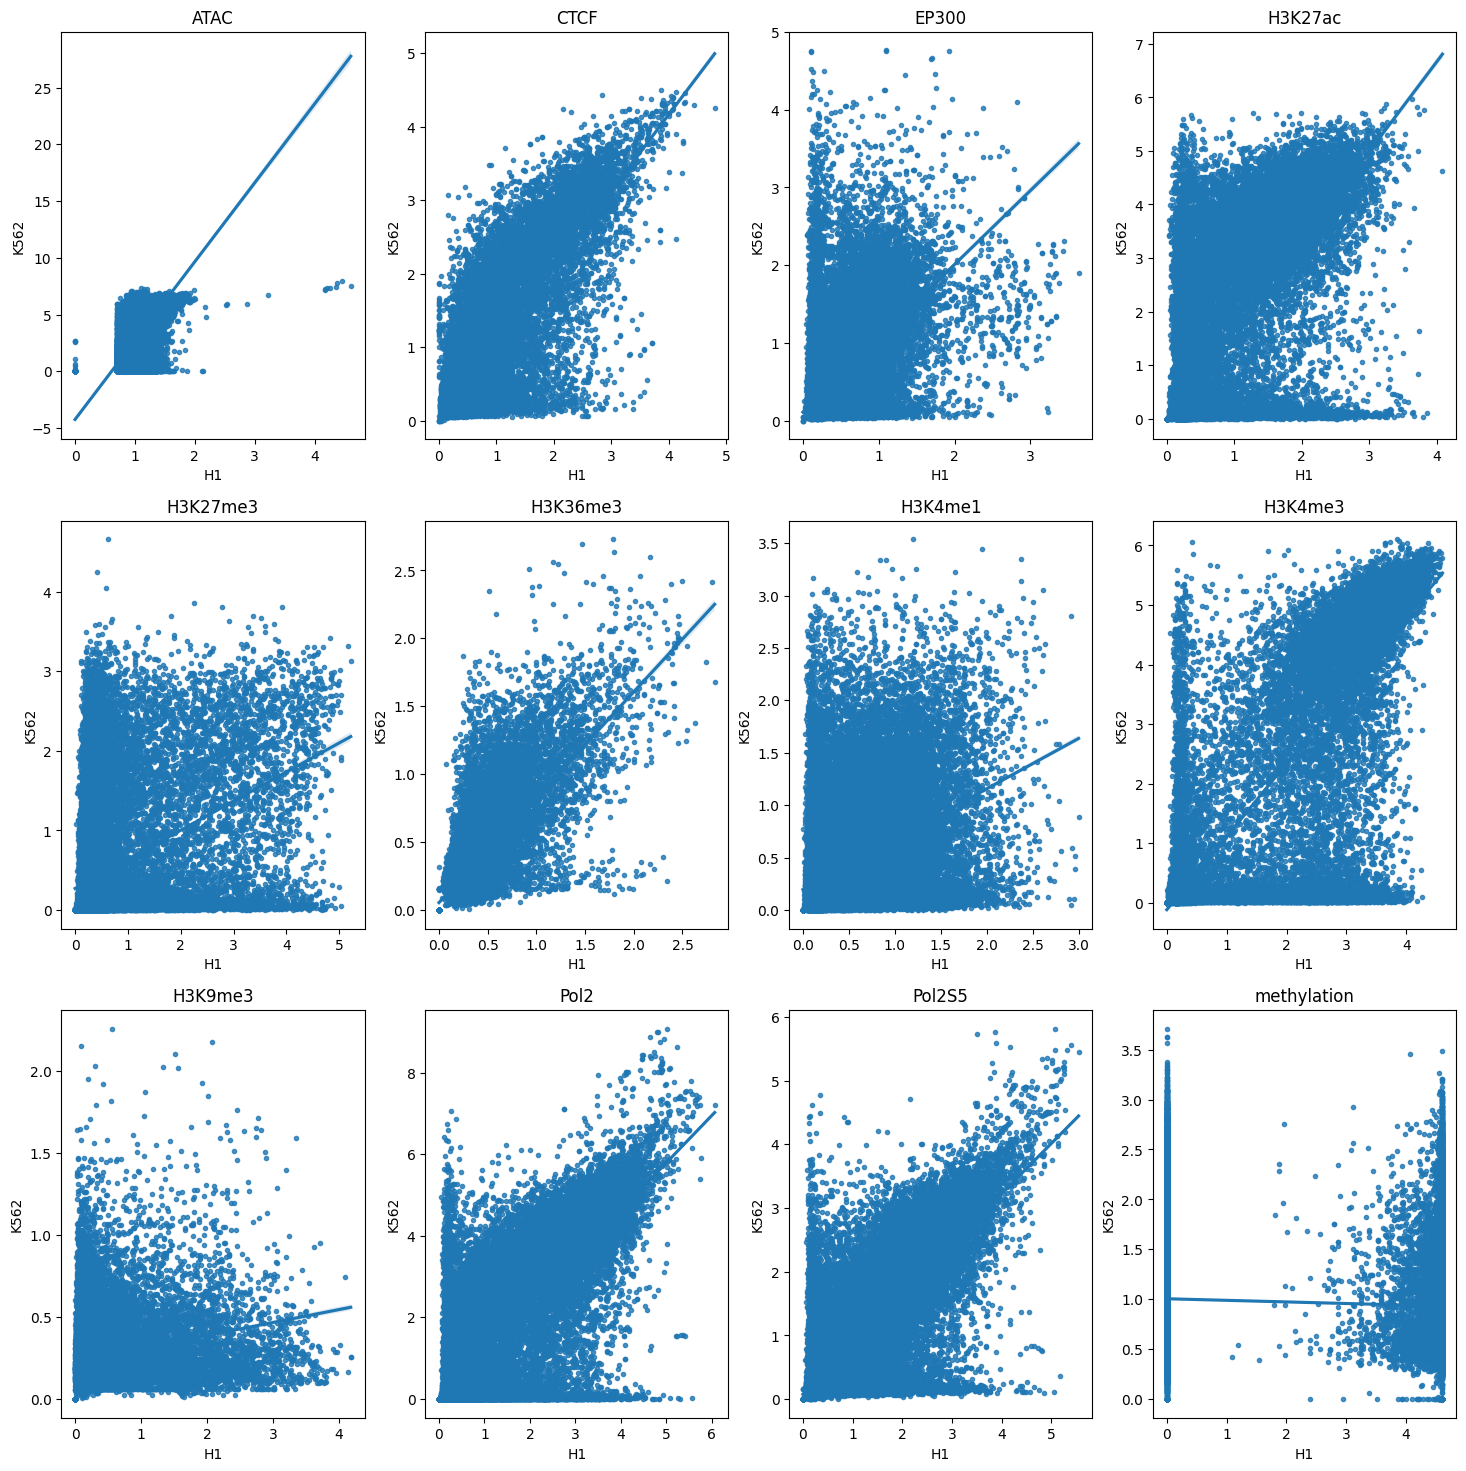

In [6]:
fig, axes = plt.subplots(3, 4, figsize=(18,18))
for col,ax in zip(['ATAC', 'CTCF', 'EP300', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1',
       'H3K4me3', 'H3K9me3', 'Pol2', 'Pol2S5', 'methylation'], axes.flatten()):
    
    
    sns.regplot(np.log1p(ds[["biosample_name", col, "gene_symbol"]].pivot_table(columns="biosample_name",values=col, index="gene_symbol")), x="H1", y="K562", marker='.', ax=ax)
    ax.set_title(col)


As we see here, most of the measurements show rough correlation and the same value scale, but some of them seem like their values are totally different (on log1p scale). Probably we should not use those. Specifically we should probably avoid `ATAC` `9me3` and `methylation` until we figure out why the scales are so different on them.

## Numerical scale

What does the distribution of values look like? We see different measurements have different levels of variability and that log scale seems to be a good idea for smoothness.

In [7]:
# Melt the dataframe: one column for 'gene' (or whatever your columns are), one for value
df_long = shared_measurements.melt(
    id_vars=shared_measurements.columns[:2],  # keep your first two columns as identifiers
    value_vars=shared_measurements.columns[2:],  # melt the rest
    var_name="feature",
    value_name="value",
)

# Drop NaNs and take log1p
df_long["log1p_value"] = np.log1p(df_long["value"])

[]

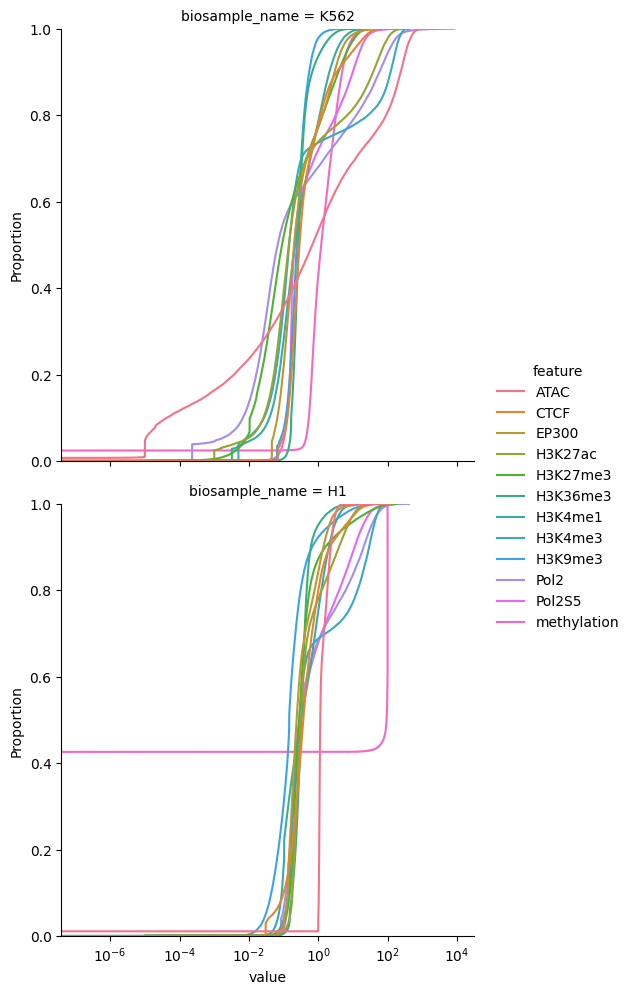

In [7]:
# Plot all together
sns.displot(
    data=df_long,
    x="value",
    hue="feature",
    row="biosample_name",
    kind="ecdf",
)
plt.semilogx()

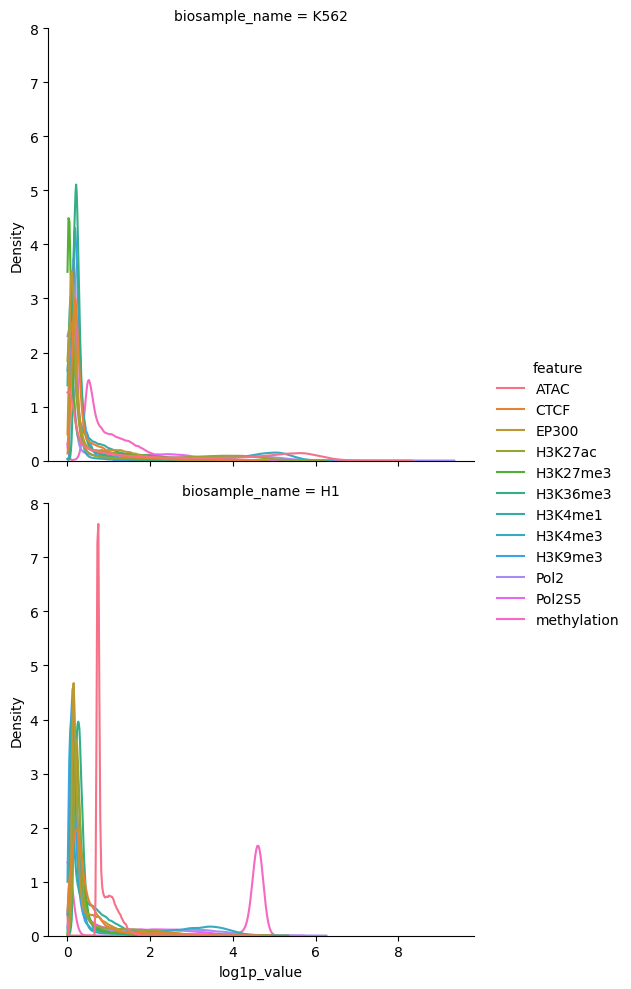

In [8]:
# Plot all together
sns.displot(
    data=df_long,
    x="log1p_value",
    hue="feature",
    row="biosample_name",
    common_norm=False,
    clip=(0, None),
    kind="kde",
    bw_adjust=0.5,
)
# plt.semilogy()

## Predictiveness of the perturbed response and the deviation from control

We'll focus on K562 now which is the subject of replogle. First let's get the pseudobulks:

In [9]:
from bmfm_targets.datasets import base_perturbation_dataset as pds
from bmfm_targets.training.metrics import perturbation_metrics as pm

replogle_gt_results_file = f"{os.environ['BMFM_TARGETS_REPLOGLE_DATA']}/replogle_logn_scgpt_split_processed.h5ad"
ad_gt = sc.read_h5ad(replogle_gt_results_file)
pertds = pds.BasePerturbationDataset(
    processed_data_source=ad_gt,
    split="test",
    split_column_name="scgpt_split",
    perturbation_column_name="gene",
)
grouped_ground_truth = pm.get_grouped_ground_truth(pertds.group_means.processed_data)
_ = grouped_ground_truth.pop("Average_Perturbation_Train")

/u/dmichael/bmfm-targets/bmfm_targets/datasets/base_perturbation_dataset.py:159: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = ad.obs.groupby(perturbation_column_name)


In [10]:
k562_data = ds.query('biosample_name == "K562"').dropna(axis=1).drop(columns="biosample_name").set_index("gene_symbol")

In [11]:
plot_data = k562_data.assign(pseudobulk = grouped_ground_truth["Control"]).query('pseudobulk >=0')


In [12]:
epicorr = plot_data.corr()

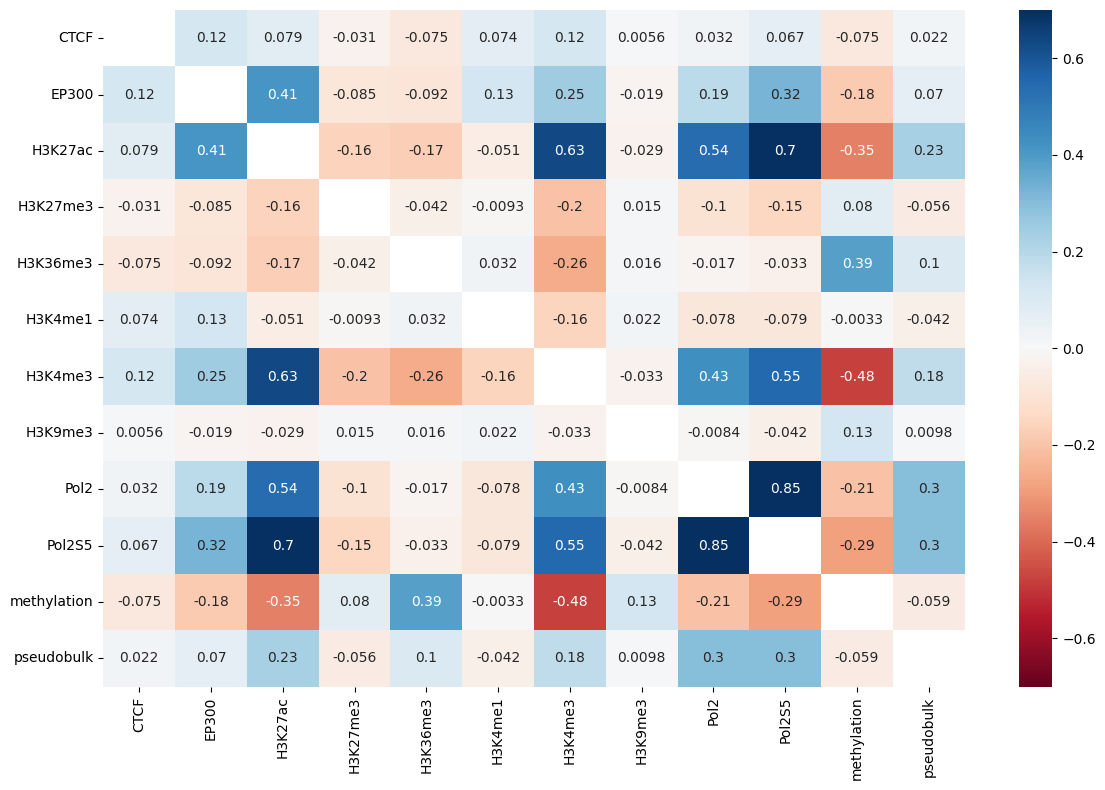

In [13]:
plt.figure(figsize=(12, 8))
sns.heatmap(epicorr.replace(1, np.nan), annot=True, cmap="RdBu", vmax=0.7, vmin=-0.7)
plt.tight_layout()

Here the focus is on the final column, the pseudobulk. We see significant correlation with `27ac` and both `Pol2` variants (which themselves are highly coordinated. Ever so slight negative correaltion with methylation which is somewhat disappointing.

## Predicting the pseudobulk from epigenetics

Now we ask ourselves, if we build a simple model can we predict the pseudobulk using the epigenetic features plus control? If so, which are predictive, if any? And which are redundant?

In [14]:
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import ElasticNetCV, LinearRegression, MultiTaskElasticNetCV
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

We'll start by doing some bootstrapped feature selection on pseudobulk prediction, to see which epigenetic features predict pseudobulk. This is sort of a baseline.

Bootstrapping ElasticNet:   0%|          | 0/200 [00:00<?, ?it/s]

             mean_coef  std_coef  nonzero_frac
H3K27ac       0.042167  0.011410         1.000
Pol2          0.085057  0.024774         1.000
H3K36me3      0.063019  0.010169         1.000
H3K4me3       0.016886  0.008665         0.985
Pol2S5        0.041239  0.023052         0.930
H3K9me3       0.005767  0.004178         0.875
EP300        -0.008341  0.006582         0.835
H3K4me1      -0.004993  0.004993         0.785
CTCF          0.004230  0.004502         0.700
methylation  -0.002638  0.004397         0.580
H3K27me3      0.000066  0.001573         0.345


<Axes: title={'center': 'ElasticNet Bootstrap Selection Frequency'}>

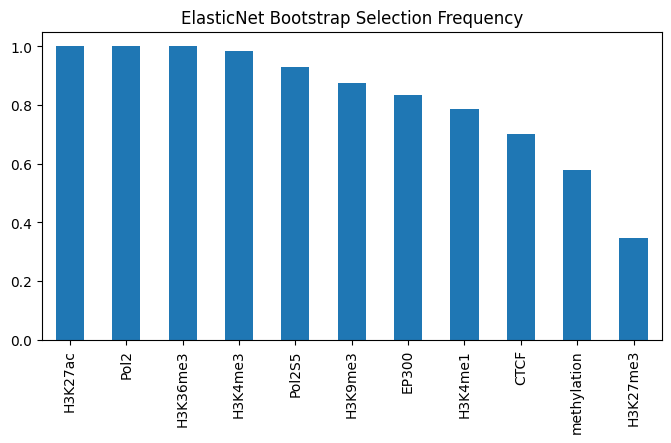

In [15]:
X = plot_data.dropna().drop(columns=["pseudobulk"])
y = plot_data.dropna()["pseudobulk"]
feature_names = X.columns

n_bootstraps = 200  # you can bump this higher if it's fast
coef_matrix = np.zeros((n_bootstraps, len(feature_names)))

for i in tqdm(range(n_bootstraps), desc="Bootstrapping ElasticNet"):
    # sample genes with replacement
    idx = np.random.choice(len(y), size=len(y), replace=True)
    Xb, yb = X.to_numpy()[idx], y.to_numpy()[idx]

    # fit ElasticNet with CV
    enet = make_pipeline(
        StandardScaler(),
        ElasticNetCV(
            l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 1.0],
            cv=5,
            random_state=i,
            max_iter=5000,
        ),
    )
    enet.fit(Xb, yb)

    coef_matrix[i, :] = enet.named_steps["elasticnetcv"].coef_

# Summarize coefficients across bootstraps
coef_df = pd.DataFrame(coef_matrix, columns=feature_names)

summary = pd.DataFrame(
    {
        "mean_coef": coef_df.mean(),
        "std_coef": coef_df.std(),
        "nonzero_frac": (coef_df != 0).mean(),  # stability selection frequency
    }
).sort_values("nonzero_frac", ascending=False)

print(summary)

# Optional: quick barplot of selection frequency
summary["nonzero_frac"].plot.bar(
    figsize=(8, 4), title="ElasticNet Bootstrap Selection Frequency"
)

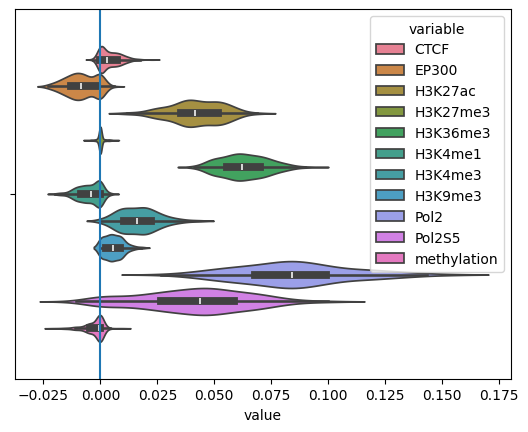

In [16]:
sns.violinplot(coef_df.melt(), hue="variable", x="value")
plt.axvline(0)

Again, we get the `Pol2` `Pol2S5` `4me3`, `36me3` and `27ac`. The rest... not much. Especially not 27me3 and methylation :(

Computing MI matrix:   0%|          | 0/12 [00:00<?, ?it/s]

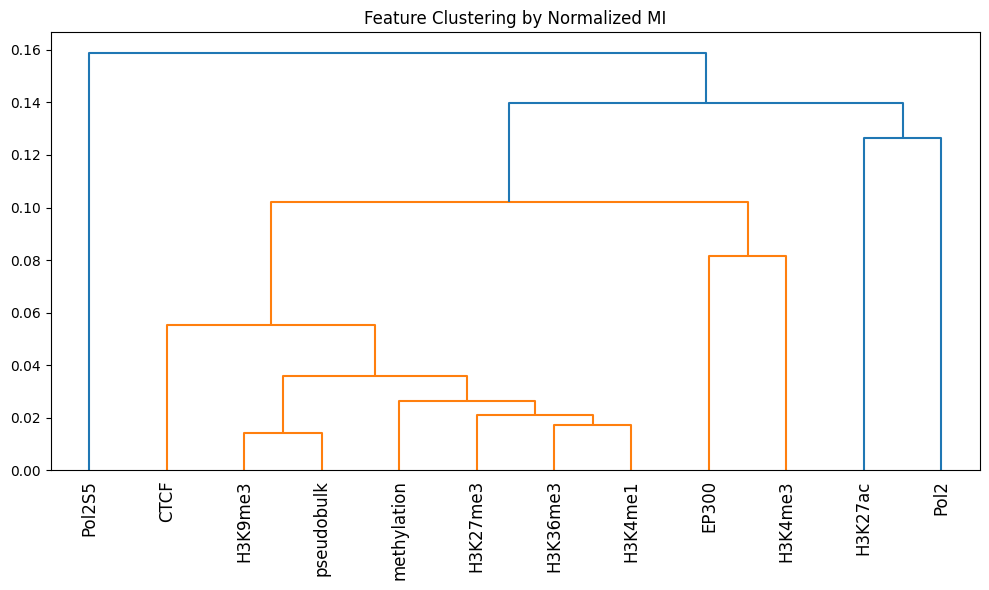

In [17]:
# scale features for MI estimation
X=plot_data.dropna()
Xs = StandardScaler().fit_transform(X)
features = X.columns


# --- 2. Pairwise normalized MI ---
def normalized_mi(x, y, n_neighbors=5):
    """Compute normalized mutual info between two continuous variables."""
    mi = mutual_info_regression(
        x.reshape(-1, 1), y, n_neighbors=n_neighbors, random_state=0
    )[0]
    hx = mutual_info_regression(
        x.reshape(-1, 1), x, n_neighbors=n_neighbors, random_state=0
    )[0]  # entropy proxy
    hy = mutual_info_regression(
        y.reshape(-1, 1), y, n_neighbors=n_neighbors, random_state=0
    )[0]
    denom = max(hx, hy)
    return mi / denom if denom > 0 else 0.0


n_features = len(features)
mi_matrix = np.zeros((n_features, n_features))

for i in tqdm(range(n_features), desc="Computing MI matrix"):
    for j in range(i + 1, n_features):
        mi_val = normalized_mi(Xs[:, i], Xs[:, j])
        mi_matrix[i, j] = mi_val
        mi_matrix[j, i] = mi_val

# --- 3. Convert to distance matrix ---
dist_matrix = 1 - mi_matrix  # similarity -> distance

# --- 4. Hierarchical clustering ---
Z = linkage(dist_matrix, method="average")

# --- 5. Dendrogram ---
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=features, leaf_rotation=90)
plt.title("Feature Clustering by Normalized MI")
plt.tight_layout()
plt.show()

Oddly, though for mutual information it looks like `9me3` and methylation and friends are closest. I don't really understand how that can be.

## Predicting the perturbed response

Now we ask ourselves, if we build a simple model can we predict the perturbed response using the epigenetic features plus control? If so, which are predictive, if any? And which are redundant?

In [18]:
epigen_df = k562_data.copy()
pseudobulk_df = grouped_ground_truth
epigen_df = (
    epigen_df.join(grouped_ground_truth.iloc[:, :2], how="inner", lsuffix="_epigenetic")
    .dropna()
    .iloc[:, :-2]
    .sort_index()
)
pseudobulk_df = (
    pseudobulk_df.join(epigen_df.iloc[:, :2], how="inner", lsuffix="_perturbation")
    .dropna()
    .iloc[:, :-2]
    .sort_index()
)

In [19]:
X = epigen_df.assign(Control = pseudobulk_df["Control"]).to_numpy()   # e.g. Pol2, ATAC, histone marks ...
Y = pseudobulk_df.drop(columns=["Control"]).to_numpy()  # columns = control, perturbA, perturbB ...
X.shape, epigen_df.shape, Y.shape, pseudobulk_df.shape

((8044, 12), (8044, 11), (8044, 1819), (8044, 1820))

In [20]:

# --- 1. Prepare data ---
# X: (n_genes, n_features) epigenetic features
# Y: (n_genes, n_conditions) pseudobulk expressions (control + perturbations)



# Example placeholders:
X = epigen_df.assign(Control = pseudobulk_df["Control"]).to_numpy()   # e.g. Pol2, ATAC, histone marks ...
Y = pseudobulk_df.drop(columns=["Control"]).to_numpy()  # columns = control, perturbA, perturbB ...

features = epigen_df.columns
conditions = pseudobulk_df.columns

# --- 2. Fit MultiTask ElasticNet ---
enet = make_pipeline(
    StandardScaler(),
    MultiTaskElasticNetCV(
        l1_ratio=[0.1, 0.5, 0.9],  # mix of L1/L2
        alphas=np.logspace(-3, 1, 20),  # regularization grid
        cv=5,
        max_iter=5000,
        random_state=0
    )
)

enet.fit(X, Y)
model = enet.named_steps["multitaskelasticnetcv"]

In [21]:
features = [*epigen_df.columns] + ["Control"]
conditions = [c for c in pseudobulk_df.columns if c!="Control"]

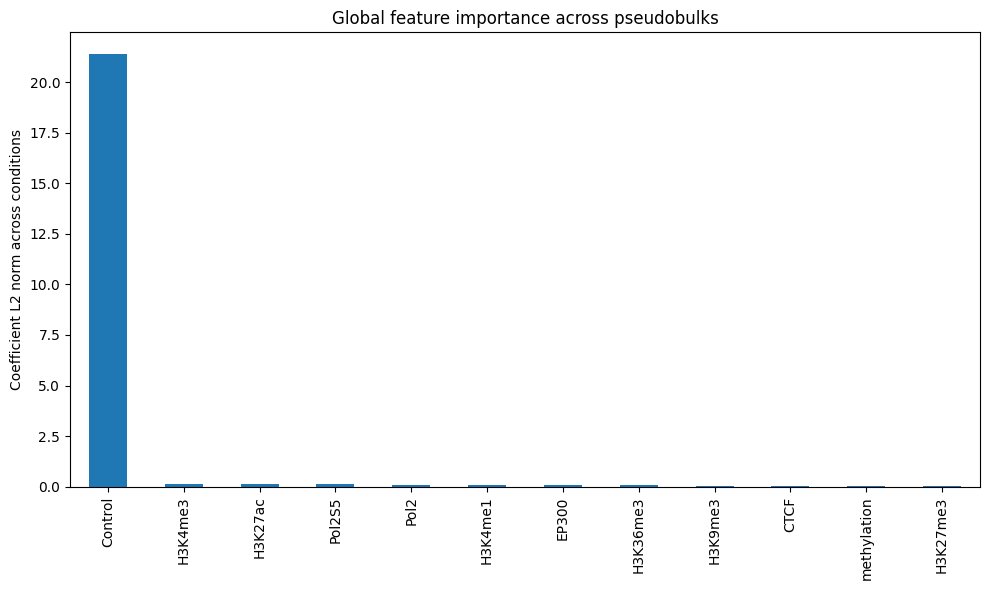

In [22]:
# --- 3. Extract coefficients ---
coef_matrix = pd.DataFrame(
    model.coef_.T,
    index=features,
    columns=conditions
)

# --- 4. Summaries ---
# row-wise norms: how strong each feature is overall
coef_matrix["row_norm"] = np.linalg.norm(coef_matrix.values, axis=1)

# variance across conditions: stability vs specificity
coef_matrix["row_std"] = coef_matrix[conditions].std(axis=1)

# Sort by overall importance
summary = coef_matrix.sort_values("row_norm", ascending=False)

# --- 5. Quick visualization ---

plt.figure(figsize=(10,6))
summary["row_norm"].plot(kind="bar")
plt.ylabel("Coefficient L2 norm across conditions")
plt.title("Global feature importance across pseudobulks")
plt.tight_layout()
plt.show()

In [23]:
print(summary["row_norm"])

Control        21.389435
H3K4me3         0.135956
H3K27ac         0.119012
Pol2S5          0.117372
Pol2            0.100622
H3K4me1         0.091995
EP300           0.076539
H3K36me3        0.068925
H3K9me3         0.049194
CTCF            0.041950
methylation     0.034273
H3K27me3        0.028293
Name: row_norm, dtype: float64


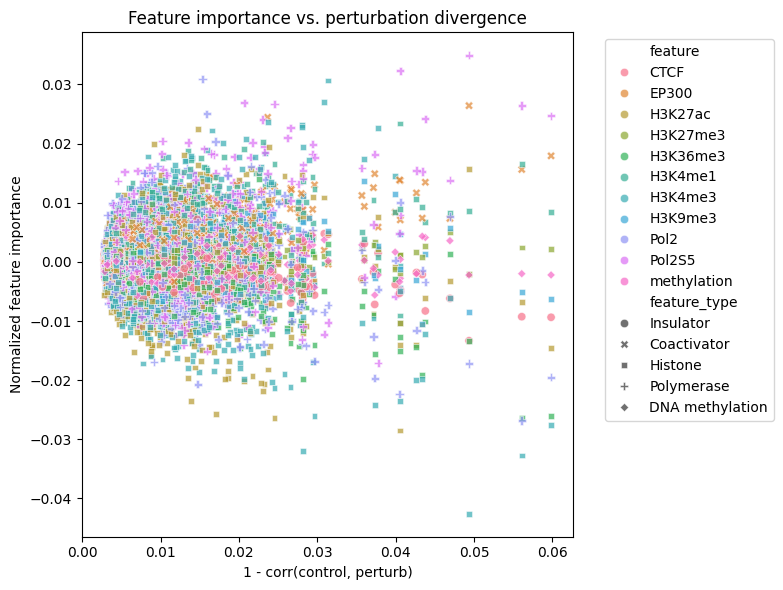

In [24]:

# --- 1. Compute perturbation distance from control ---
control = pseudobulk_df["Control"].values
pert_dists = {}
for cond in pseudobulk_df.columns:
    if cond == "Control":
        continue
    corr = np.corrcoef(control, pseudobulk_df[cond].values)[0,1]
    pert_dists[cond] = 1 - corr

pert_dists = pd.Series(pert_dists, name="pert_distance")

# --- 2. Get normalized feature importances per condition ---
coef_matrix = coef_matrix[conditions]  # features x conditions
normed = coef_matrix.div(np.linalg.norm(coef_matrix.values, axis=0), axis=1)
# (each column normalized by L2 norm)

# --- 3. Melt into long format for plotting ---
plot_df = (
    normed
    .reset_index()
    .melt(id_vars="index", var_name="condition", value_name="importance")
    .rename(columns={"index":"feature"})
)
plot_df = plot_df.merge(
    pert_dists.reset_index().rename(columns={"index":"condition"}),
    on="condition",
    how="left"
)

# --- 4. Add feature type annotation (custom mapping) ---
feature_types = {
    "Pol2": "Polymerase",
    "Pol2S5": "Polymerase",
    "ATAC": "Accessibility",
    "DNase": "Accessibility",
    "H3K36me3": "Histone",
    "H3K4me3": "Histone",
    "H3K27ac": "Histone",
    "H3K9me3": "Histone",
    "H3K27me3": "Histone",
    "H3K4me1": "Histone",
    "EP300": "Coactivator",
    "CTCF": "Insulator",
    "methylation": "DNA methylation",
    "Control":"Control"
}
plot_df["feature_type"] = plot_df["feature"].map(feature_types)

# --- 5. Scatterplot ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=plot_df.query('feature != "Control"'),
    x="pert_distance",
    y="importance",
    hue="feature",
    style="feature_type",
    alpha=0.7
)
plt.xlabel("1 - corr(control, perturb)")
plt.ylabel("Normalized feature importance")
plt.title("Feature importance vs. perturbation divergence")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


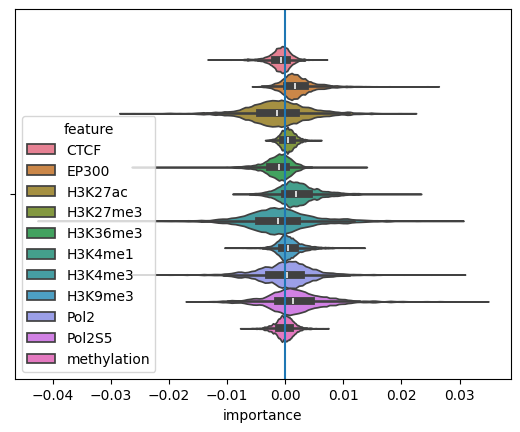

In [25]:
sns.violinplot(
    data=plot_df.query('feature != "Control"'),
    x="importance",
    hue="feature",
    cut=0,
    bw_adjust=0.3
)
plt.axvline(0)

In [26]:
results = []

for cond in tqdm(conditions):
    if cond == "Control":
        continue

    y = pseudobulk_df[cond].values.reshape(-1, 1)
    X_control = pseudobulk_df["Control"].values.reshape(-1, 1)

    # baseline model
    base = LinearRegression().fit(X_control, y)
    base_r2 = r2_score(y, base.predict(X_control))

    for f in features:
        if f == "Control":
            continue
        X_aug = np.column_stack([X_control, epigen_df[f].values])
        aug = LinearRegression().fit(X_aug, y)
        aug_r2 = r2_score(y, aug.predict(X_aug))

        results.append(
            {
                "condition": cond,
                "feature": f,
                "delta_r2": aug_r2 - base_r2,
                "feature_type": feature_types[f],
            }
        )

df_conditional_importance = pd.DataFrame(results)

  0%|          | 0/1819 [00:00<?, ?it/s]

In [27]:
df_conditional_importance.groupby('feature').mean(numeric_only=True).squeeze().sort_values()

feature
H3K27me3       0.000004
CTCF           0.000004
H3K9me3        0.000006
methylation    0.000006
H3K36me3       0.000012
EP300          0.000018
Pol2S5         0.000021
Pol2           0.000022
H3K4me1        0.000026
H3K27ac        0.000026
H3K4me3        0.000033
Name: delta_r2, dtype: float64

In [28]:
model = smf.ols('delta_r2 ~ 0 + C(feature)', data=df_conditional_importance).fit()

In [29]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               delta_r2   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     119.3
Date:                Mon, 03 Nov 2025   Prob (F-statistic):          1.11e-242
Time:                        16:43:46   Log-Likelihood:             1.7416e+05
No. Observations:               20009   AIC:                        -3.483e+05
Df Residuals:                   19998   BIC:                        -3.482e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
C(feature)[CTCF]         4.459e-06   9.41e-07      4.737      0.000    2.61e-06     6.3e-06
C(feature)[EP300]        1.833e-05   9.41e-07     19.471      0.000    1.65e-05    2.02e-05
C(feature)[H3K27ac]      2.647e-05   9.41e-07     28.125      0.000    2.46e-05    2.83e-05
C(feature)[H3K27me3]     4.393e-06   9.41e-07      4.666      0.000    2.55e-06    6.24e-06
C(feature)[H3K36me3]     1.153e-05   9.41e-07     12.254      0.000    9.69e-06    1.34e-05
C(feature)[H3K4me1]      2.633e-05   9.41e-07     27.968      0.000    2.45e-05    2.82e-05
C(feature)[H3K4me3]      3.343e-05   9.41e-07     35.516      0.000    3.16e-05    3.53e-05
C(feature)[H3K9me3]      6.322e-06   9.41e-07      6.716      0.000    4.48e-06    8.17e-06
C(feature)[Pol2]         2.198e-05   9.41e-07     23.347      0.000    2.01e-05    2.38e-05
C(feature)[Pol2S5]       2.098e-05   9.41e-07     22.290      0.000    1.91e-05    2.28e-05
C(feature)[methylation]  6.452e-06   9.41e-07      6.854      0.000    4.61e-06     8.3e-06
==============================================================================
Omnibus:                    27081.802   Durbin-Watson:                   1.336
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8387237.214
Skew:                           7.722   Prob(JB):                         0.00
Kurtosis:                     102.104   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
model.params.sort_values()

C(feature)[H3K27me3]       0.000004
C(feature)[CTCF]           0.000004
C(feature)[H3K9me3]        0.000006
C(feature)[methylation]    0.000006
C(feature)[H3K36me3]       0.000012
C(feature)[EP300]          0.000018
C(feature)[Pol2S5]         0.000021
C(feature)[Pol2]           0.000022
C(feature)[H3K4me1]        0.000026
C(feature)[H3K27ac]        0.000026
C(feature)[H3K4me3]        0.000033
dtype: float64